### Section 4: Digging into regression mechanics

Today, we will look at some coding in R. You will be learning
* how to look at and summarize your data
* how to run basic regressions
* how to interpret regression outputs
* how to interpret some of the most important techniques when running regressions
* how to visualize data and regression results (more on that next time!)

We will be using a (fictional) dataset on wages in California. We are interested whether there is a "gender wage gap", and how education and age affect one's earnings.

By now, you should know how to read in data. I will not be going over this. Instead, I will just show a piece of code that generates the dataset which we will be using. This can be useful because we already know the truth and can check whether our estimates make sense.

You do not need to understand everything in this section, but feel free to use Copilot or an LLM to get a step-by-step explanation of what this code is doing.

In [1]:
set.seed(123456789)
dataset = data.frame(seq(1, 3000))
dataset$n = dataset$seq.1..3000.
dataset$seq.1..3000.=NULL
dataset$male = 0
dataset$male[dataset$n>=1613]=1
dataset$n = NULL

# Individual effect
dataset$individual = rnorm(3000,0,1)
# Gender effect (related to education)
dataset$rgender = rbinom(3000, 1, 0.1)*dataset$male


sampleDist = function(n) { 
    sample(x = c(8,9,10,11,12,13,14,15,16,9,10,11,12,13,14,10,11,15,12,17,17,10,12,11,13,15,15,14, 12, 12, 16, 11, 10, 10, 7, 10, 12, 12, 15, 15, 8, 9, 10, 12), n, replace = T) 
    }

# Make education variable
dataset$education = sampleDist(3000)
dataset$education = round(dataset$education+dataset$rgender*4*runif(3000,1,2)+rnorm(3000,0,0.1),digits=0)
dataset$education[dataset$education<=4] = 7
dataset$education[dataset$education==5] = 7
dataset$education[dataset$education==6] = 8

# Played videogames in childhood
dataset$videogames_childhood = round(runif(3000,0,8),digits=1)

# Education squared
dataset$educationsquared = (dataset$education)*(dataset$education)

# Wages
dataset$wage_monthly = 2000 + 100*dataset$individual + 50*dataset$male + 100*(dataset$education)

dataset$meduc = dataset$male*dataset$education
# Hourly wages
dataset$wage_hourly = 10 + 2*dataset$individual + 2*dataset$male + 1.5*(dataset$education) - 1*dataset$meduc
# Age
dataset$age = round(runif(3000,25,70),digits=0)
dataset$agesquared = dataset$age*dataset$age
# Yearly wages
dataset$wage_yearly = 15000 + 1000*dataset$education + 1000*dataset$age - 9*dataset$agesquared + 1000*dataset$individual

dataset$individual = NULL
dataset$rgender = NULL
dataset$n = NULL
dataset$agesquared = NULL
dataset$educationsquared=NULL
dataset$meduc=NULL

dataset$male[dataset$male==0]="Female"
dataset$male[dataset$male==1]="Male"
print("Dataset successfully generated")

[1] "Dataset successfully generated"


# Revision

Do this part as exercise at your own time - we will not go over it in section.

Let us have a look at the data:

In [2]:
colnames(dataset)
head(dataset)

[1] "male"                 "education"            "videogames_childhood"
[4] "wage_monthly"         "wage_hourly"          "age"                 
[7] "wage_yearly"

,male,education,videogames_childhood,wage_monthly,wage_hourly,age,wage_yearly
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Female,15,6.2,3550.487,33.50974,67,57103.87
2,Female,12,7.5,3239.588,28.79175,35,51370.88
3,Female,15,1.4,3641.554,35.33108,51,59006.54
4,Female,9,5.2,2827.768,22.05535,41,49148.68
5,Female,12,5.8,3138.164,26.76329,39,51692.64
6,Female,12,0.1,3043.738,24.87476,27,45876.38


A couple of warm-up quiz questions for you:
* How many observations are there in the dataset?
* How many variables are there in the dataset?
* What proportion of the data is male?
* What is the average monthly wage in the data?

In [3]:
dim(dataset)

# Male-female

# mean(data$male)
# Ouch! Need to convert data - this is character, not numeric

# Alternative 1: Recode values using dplyr and recode function
library(dplyr)
dataset$male = as.numeric(recode(dataset$male, "Male" = 1, "Female"=0))

# Alternative 2: Manually
# dataset$male[dataset$male=="Male"]=1
# dataset$male[dataset$male=="Female"]=0
# dataset$male = as.numeric(dataset$male)


mean(dataset$male)

mean(dataset$wage_monthly)

# Let us format these in a nicer way
print(round(mean(dataset$male),2))
print(round(mean(dataset$wage_monthly),10))

[1] 3000    7


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 0.4626667

[1] 3256.691

[1] 0.46
[1] 3256.691


Let us summarize the education data. What are mean and standard deviation? How does the data look like? Is there anything you notice?

You can do the same thing for monthly wages. Are there any outliers? How would you treat them?

[1] 12.306

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.00   10.00   12.00   12.31   14.00   25.00 

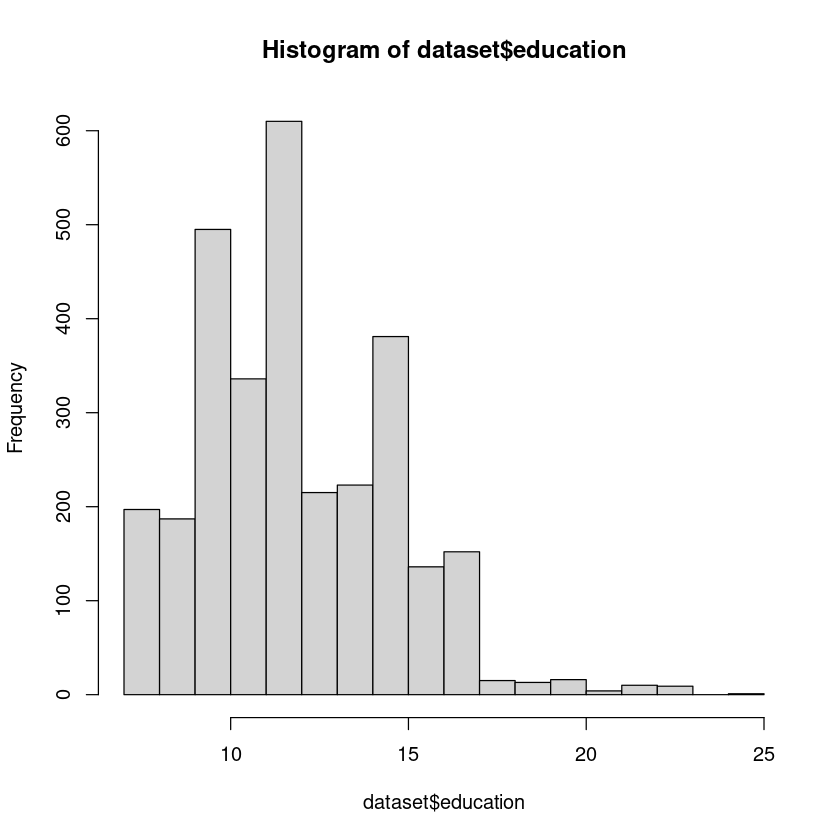

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2445    3046    3225    3257    3460    4704 

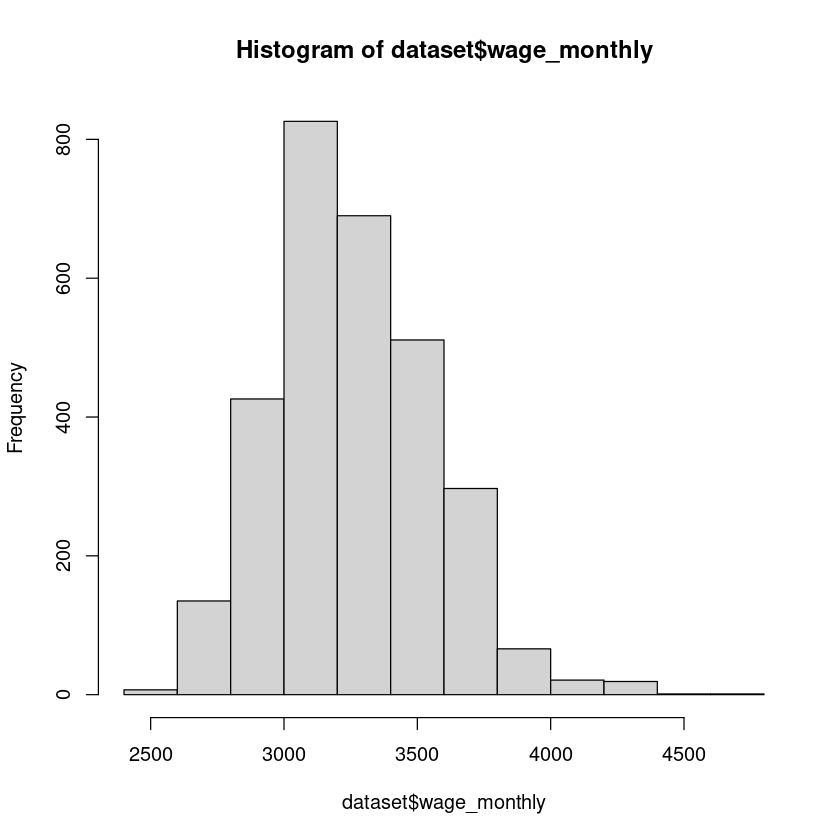

In [4]:
mean(dataset$education)
summary(dataset$education)
hist(dataset$education)

hist(dataset$wage_monthly)
summary(dataset$wage_monthly)

We don't see any outliers in the wage data. We could either drop outliers from our analysis, or we could recode them as a high non-outlier value.

## Digging more into the data: Is there a gender wage gap?

We start with a basic linear model of wages ($w_i$), which we regress on gender ($m_i$):

$$
w_i = \alpha + \beta_m \cdot \text{male}_i + \epsilon_i
$$

How would you run this in ```R```?

In [5]:
gender_regression = summary(lm(wage_monthly ~ male , data=dataset))
print(gender_regression)



Call:
lm(formula = wage_monthly ~ male, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-755.30 -209.43  -26.06  201.42 1381.96 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3200.333      7.262  440.68   <2e-16 ***
male         121.810     10.677   11.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 291.6 on 2998 degrees of freedom
Multiple R-squared:  0.04161,	Adjusted R-squared:  0.04129 
F-statistic: 130.2 on 1 and 2998 DF,  p-value: < 2.2e-16



Let us interpret this regression output. 
* **What is the meaning of the intercept?**
Answer: The intercept is always the 'conditional mean': The expected value of the outcome variable, conditional on all other variables being zero. Here, it is simply the average wage for females (male=0).
* **What is the meaning of the coefficient on "male"?**
This shows the difference in average wages between males and females.
* **What do the other parts of the output mean?**
Interpretation of standard error (measure of precision of estimate: The smaller the standard error, the more precise the estimate), and t-statistic (coefficient divided by standard error). A t-statistic above 2 is equivalent to a p-value below 0.05. 
In this case, we could also reject the null hypothesis that males earn 100$ more than females - 121 (coefficient) minus 2*10 (standard error) gives a bit more than 100.

* **Can you interpret the coefficient as the "gender wage gap"?**
Maybe. This is an "unconditional wage gap" - but we cannot interpret this as a causal or discrimination effect.


Below we see that just taking means exactly corresponds to the regression output - but we can do so much more with regressions.

In [6]:
mean(dataset$wage_monthly[dataset$male==0])
mean(dataset$wage_monthly[dataset$male==1])

mean(dataset$wage_monthly[dataset$male==1]) - mean(dataset$wage_monthly[dataset$male==0])

[1] 3200.333

[1] 3322.143

[1] 121.8096

Let us consider whether videogames are determinants of wages. Let's include this in the regression as well.

In [7]:
# Include videogames
example_regression = summary(lm(wage_monthly ~ education + male + videogames_childhood , data=dataset))
print(example_regression)



Call:
lm(formula = wage_monthly ~ education + male + videogames_childhood, 
    data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-361.40  -67.91   -0.56   70.07  364.62 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          2001.1694     9.1823  217.94   <2e-16 ***
education              99.8057     0.6789  147.02   <2e-16 ***
male                   54.8529     3.7536   14.61   <2e-16 ***
videogames_childhood    0.4836     0.8064    0.60    0.549    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 101.8 on 2996 degrees of freedom
Multiple R-squared:  0.8834,	Adjusted R-squared:  0.8833 
F-statistic:  7564 on 3 and 2996 DF,  p-value: < 2.2e-16



**How would you interpret this regression? How do you interpret the constant here - and what about the coefficients on male and videogames?**
Answer: The coefficient on videogame is not statistically different from zero. The intercept now is the expected earnings for individuals with zero years of education, who are female, and played zero hours of videogames in their childhood.

### Omitted variable bias

Since we also have education in our dataset, let us use it. Do you think education might be an "omitted variable"?

**How does our estimate of the "gender wage gap" change if we include education as an additional variable in the regression?** 


In [8]:
full_regression = summary(lm(wage_monthly ~ education + male , data=dataset))
print(full_regression)


Call:
lm(formula = wage_monthly ~ education + male, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-360.68  -68.17   -0.25   70.47  365.97 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2003.2132     8.5255  234.97   <2e-16 ***
education     99.7961     0.6786  147.06   <2e-16 ***
male          54.8694     3.7531   14.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 101.7 on 2997 degrees of freedom
Multiple R-squared:  0.8834,	Adjusted R-squared:  0.8833 
F-statistic: 1.135e+04 on 2 and 2997 DF,  p-value: < 2.2e-16



### The OVB formula
We saw above that our estimate of the gender wage gap has become smaller once we control for education. 


To formally investigate how the estimate for one coefficient changes if we include more variables in the regression, we do a small experiment. 

We will be running three regressions:
* 1: Full regression: Include gender and education
* 2: Short (biased) regression: Incldue gender only
* 3: Auxiliary regression: Regress education on gender

Can you find a relation between the coefficients?

In [9]:
full_regression = summary(lm(wage_monthly ~ education + male , data=dataset))
print(full_regression)

true_coefficient = full_regression$coefficients[3,1]
omitted_coefficient = full_regression$coefficients[2,1]

short_regression = summary(lm(wage_monthly ~ male, data=dataset))
print(short_regression)
biased_coefficient = short_regression$coefficients[2,1]

auxiliary_regression =summary(lm(education ~ male, data=dataset))
print(auxiliary_regression)
auxiliary_coefficient = auxiliary_regression$coefficients[2,1]

print(biased_coefficient)
print(true_coefficient + auxiliary_coefficient*omitted_coefficient)



Call:
lm(formula = wage_monthly ~ education + male, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-360.68  -68.17   -0.25   70.47  365.97 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2003.2132     8.5255  234.97   <2e-16 ***
education     99.7961     0.6786  147.06   <2e-16 ***
male          54.8694     3.7531   14.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 101.7 on 2997 degrees of freedom
Multiple R-squared:  0.8834,	Adjusted R-squared:  0.8833 
F-statistic: 1.135e+04 on 2 and 2997 DF,  p-value: < 2.2e-16


Call:
lm(formula = wage_monthly ~ male, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-755.30 -209.43  -26.06  201.42 1381.96 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3200.333      7.262  440.68   <2e-16 ***
male         121.810     10.677   11.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘

### The Omitted Variable Bias Formula

From these regressions, we see that there is the following relation between the coefficients:

$$ \rho_s = \rho + \gamma \cdot \delta $$

where $\rho$ is the "long" coefficient, $\gamma$ is the coefficient of the omitted variable in the long regression, $\delta$ is the coefficient in the auxiliary regression, and $\rho_s$ is the "short" regression coefficient.

This relation is ALWAYS true - no matter whether we consider causality or now.

We can think about this to think about the direction of bias - in a crude way. In our case, $\gamma$ is positive, and $\delta$ is positive as well - so the coefficient from the "short" regression is larger than the coefficient from the "long" regression - as we saw in the regression output!

Let us take a different example. We want to know whether a (non-random) support program for low-income students in a local high school increased their test scores. We regress test scores on the support program and find a negative coefficient. Does this mean that the program had a negative effect on grades?

No! We can use the OVB formula to think about the most important omitted variable in this case: Parents' education (and income, etc.). The higher parents' income, the lower the probability that a child is eligible for the support program ($\delta<0$). At the same time, the higher parents' education, the better childrens' test scores tend to be ($\gamma>0$). Therefore, we expect a negative bias: The coefficient when just running test scores on the program is smaller than if we include parents' education! **Neat!**


## Wage and age: Exploring a life-cycle relationship

We may also be interested in the relation between age and wages (for this part of the analysis, we use yearly wages). What do you think this relationship may look like? Will wages increase in age or become smaller as people become older?

Let us make a plot!

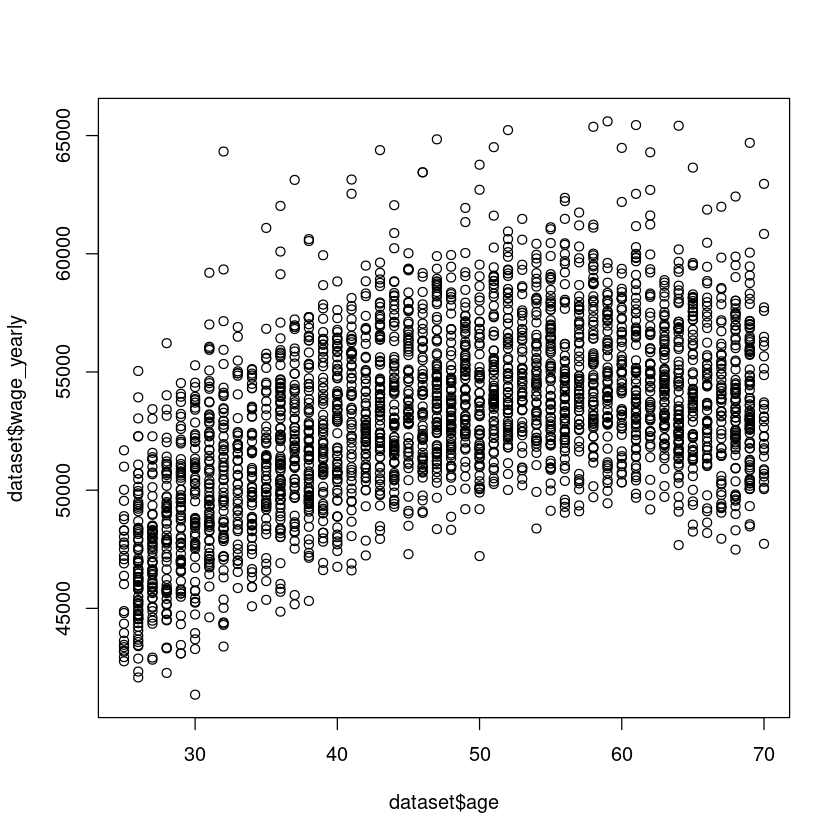

In [12]:
plot(dataset$age, dataset$wage_yearly)

How does this data look like? Do you think a simple linear model would fully capture the relationship between age age wages? What would you do to solve this issue?

Let us generate a new variable that is the square of the age. This looks like a parabola, so maybe we will be able to fit the data with a quadratic model.

In [13]:
dataset$agesquared = dataset$age*dataset$age

We now have a regression model that looks like this:

$$
w_i = \alpha + \beta_1 \cdot \text{age}_i + \beta_2 \cdot \text{age}_i^2 + \epsilon_i
$$

**How do we expect $w_i$ to change if age goes up by one year?**
This is just so awesome. The effect of age on wage can now be different for different values of age. To see this, we can just take a derivative:

$$
\frac{d\text{wage}_i}{d\text{age}_i} = \beta_1 + 2*\beta_2 \cdot \text{age}_i
$$

The derivative changes with age!

Let us run the regression with the squared term:

In [14]:
quadratic_regression = summary(lm(wage_yearly ~ education + age + agesquared , data=dataset))
print(quadratic_regression)

# Sidenote: There is a "more elegant" way to do it:
quadratic_regression = summary(lm(wage_yearly ~ education + age + I(age^2) , data=dataset))
print(quadratic_regression)


Call:
lm(formula = wage_yearly ~ education + age + agesquared, data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-3670.7  -676.3    -8.2   704.4  3680.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14853.5572   279.4781   53.15   <2e-16 ***
education     999.1820     6.7372  148.31   <2e-16 ***
age          1005.3263    11.6659   86.18   <2e-16 ***
agesquared     -9.0277     0.1216  -74.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1017 on 2996 degrees of freedom
Multiple R-squared:  0.9252,	Adjusted R-squared:  0.9251 
F-statistic: 1.236e+04 on 3 and 2996 DF,  p-value: < 2.2e-16


Call:
lm(formula = wage_yearly ~ education + age + I(age^2), data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-3670.7  -676.3    -8.2   704.4  3680.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14853.5572   279.4781   53.15   <2e-1

We can now also calculate the "tipping point" by setting the derivative from above to zero.
$$
\frac{d\text{wage}_i}{d\text{age}_i} = 0 \\
\Leftrightarrow 0 = \beta_1 + 2\beta_2 \cdot \text{age}_i
\Leftrightarrow \text{age}_i = - \frac{\beta_1}{2\beta_2}
$$
Plugging this in, we get $1005/(2*9)\approx 56$ years as the tipping point.


## Interpreting Interaction Terms (NEXT WEEK)

Maybe the effect of education is different between male and female respondents. To investigate this, we can use a technique called "Interaction Terms". Let us first create a variable that is the product of male and education.

In [10]:
dataset$male_times_education = dataset$male*dataset$education


We will be using hourly wages instead of monthly wages for this analysis. 
Our regression model looks like this. 

$$
w_i = \alpha + \beta_m \cdot \text{male}_i + \beta_e \cdot \text{education}_i + \beta_{me} \cdot \text{male}_i \cdot \text{education}_i + \epsilon_i
$$


How would we interpret the coefficients?

* Interpret $\beta_m$
* Interpret $\beta_e$
* Interpret $\beta_{me}$


Let us run the regression and have a look at the results:

In [11]:
interact_regression = summary(lm(wage_hourly ~ education + male + male_times_education , data=dataset))
print(interact_regression)

# Sidenote: There is a "more correct" way to do it:
interact_regression = summary(lm(wage_hourly ~ education + male + I(male*education) , data=dataset))
print(interact_regression)


Call:
lm(formula = wage_hourly ~ education + male + male_times_education, 
    data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2015 -1.3734 -0.0039  1.4061  7.2704 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           9.91772    0.25084  39.538  < 2e-16 ***
education             1.50814    0.02048  73.641  < 2e-16 ***
male                  2.36515    0.34440   6.867 7.91e-12 ***
male_times_education -1.02179    0.02735 -37.362  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.035 on 2996 degrees of freedom
Multiple R-squared:  0.8831,	Adjusted R-squared:  0.8829 
F-statistic:  7541 on 3 and 2996 DF,  p-value: < 2.2e-16


Call:
lm(formula = wage_hourly ~ education + male + I(male * education), 
    data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2015 -1.3734 -0.0039  1.4061  7.2704 

Coefficients:
                    Estimate Std. Error

In [ ]:

## Summary: What we learned

Today, we:
* Practiced how to interpret the output of linear regressions
* looked at what happens if we forget to include an important variable in our regression: **omitted variable bias**!
* Learned two key techniques which allow us to analyze much more rich economic patterns in the world: Quadratic Terms and Interaction effects (**NEXT WEEK**).